$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$
# Part 1: Binary Classification with Multilayer Perceptrons
<a id=part1></a>

In this part we'll implement a general purpose MLP and Binary Classifier using `pytorch`.
We'll implement its training, and also learn about decision boundaries an threshold selection in the context of binary classification. Finally, we'll explore the effect of depth and width on an MLP's performance.

In [1]:
import os
import re
import sys
import glob
import unittest
from typing import Sequence, Tuple

import sklearn
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as tvtf
from torch import Tensor

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

device is cuda


## Synthetic Dataset

To test our first neural network-based classifiers we'll start by creating a toy binary classification dataset, but one which is not trivial for a linear model.

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [4]:
def rotate_2d(X, deg=0):
    """
    Rotates each 2d sample in X of shape (N, 2) by deg degrees.
    """
    a = np.deg2rad(deg)
    return X @ np.array([[np.cos(a), -np.sin(a)],[np.sin(a), np.cos(a)]]).T

def plot_dataset_2d(X, y, n_classes=2, alpha=0.2, figsize=(8, 6), title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    for c in range(n_classes):
        ax.scatter(*X[y==c,:].T, alpha=alpha, label=f"class {c}");
        
    ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$");
    ax.legend(); ax.set_title((title or '') + f" (n={len(y)})")

We'll split our data into 80% train and validation, and 20% test.
To make it a bit more challenging, we'll simulate a somewhat real-world setting where there are multiple populations, and the training/validation data is not sampled iid from the underlying data distribution.

In [5]:
np.random.seed(seed)

N = 10_000
N_train = int(N * .8)

# Create data from two different distributions for the training/validation
X1, y1 = make_moons(n_samples=N_train//2, noise=0.2)
X1 = rotate_2d(X1, deg=10)
X2, y2 = make_moons(n_samples=N_train//2, noise=0.25)
X2 = rotate_2d(X2, deg=50)

# Test data comes from a similar but noisier distribution
X3, y3 = make_moons(n_samples=(N-N_train), noise=0.3)
X3 = rotate_2d(X3, deg=40)

X, y = np.vstack([X1, X2, X3]), np.hstack([y1, y2, y3])

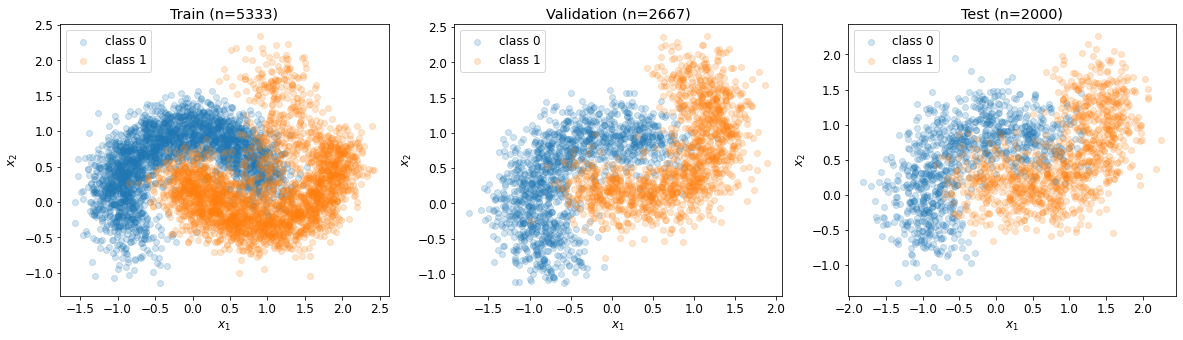

In [6]:
# Train and validation data is from mixture distribution
X_train, X_valid, y_train, y_valid = train_test_split(X[:N_train, :], y[:N_train], test_size=1/3, shuffle=False)

# Test data is only from the second distribution
X_test, y_test = X[N_train:, :], y[N_train:]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
plot_dataset_2d(X_train, y_train, title='Train', ax=ax[0]);
plot_dataset_2d(X_valid, y_valid, title='Validation', ax=ax[1]);
plot_dataset_2d(X_test, y_test, title='Test', ax=ax[2]);

Now let us create a data loader for each dataset.

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 32

dl_train, dl_valid, dl_test = [
    DataLoader(
        dataset=TensorDataset(
            torch.from_numpy(X_).to(torch.float32),
            torch.from_numpy(y_)
        ),
        shuffle=True,
        num_workers=0,
        batch_size=batch_size
    )
    for X_, y_ in [(X_train, y_train), (X_valid, y_valid), (X_test, y_test)]
]

print(f'{len(dl_train.dataset)=}, {len(dl_valid.dataset)=}, {len(dl_test.dataset)=}')

len(dl_train.dataset)=5333, len(dl_valid.dataset)=2667, len(dl_test.dataset)=2000


## Simple MLP

A multilayer-perceptron is arguably a the most basic type of neural network model.
It is composed of $L$ **layers**, each layer $l$ with $n_l$ **perceptron** ("neuron") units.
Each perceptron is connected to all ouputs of the previous layer (or all inputs in the first layer), calculates their weighted sum, applies a linearity and produces a single output.

<center><img src="imgs/mlp.png" width=1000 /></center>

Each layer $l$ operates on the output of the previous layer ($\vec{y}_{l-1}$) and calculates:

$$
\vec{y}_l = \varphi\left( \mat{W}_l \vec{y}_{l-1} + \vec{b}_l \right),~
\mat{W}_l\in\set{R}^{n_{l}\times n_{l-1}},~ \vec{b}_l\in\set{R}^{n_l},~ l \in \{1,2,\dots,L\}.
$$

- Note that both input and output are **vectors**. We can think of the above equation as describing a layer of **multiple perceptrons**.
- We'll henceforth refer to such layers as **fully-connected** or FC layers.
- The first layer accepts the input of the model, i.e. $\vec{y}_0=\vec{x}\in\set{R}^d$.
- The last layer, $L$, is the output layer, so $y_L$ is the output of the model.
- The layers $1, 2, \dots, L-1$ are called hidden layers.

To begin, let's implement a general multi-layer perceptron model.
We'll seek to implement it in a way which is both general in terms of architecture, and also composable so that we can use our MLP in the context of larger models.

**TODO**: Implement the `MLP` class in the `hw2/mlp.py` module.

In [8]:
from hw2.mlp import MLP

mlp = MLP(
    in_dim=2,
    dims=[8, 16, 32, 64],
    nonlins=['relu', 'tanh', nn.LeakyReLU(0.314), 'softmax']
)
mlp

MLP(
  (fc_layers): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.314)
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): Softmax(dim=1)
  )
)

Let's try our implementation on a batch of data.

In [9]:
x0, y0 = next(iter(dl_train))

yhat0 = mlp(x0)

test.assertEqual(len([*mlp.parameters()]), 8)
test.assertEqual(yhat0.shape, (batch_size, mlp.out_dim))
test.assertTrue(torch.allclose(torch.sum(yhat0, dim=1), torch.tensor(1.0)))
test.assertIsNotNone(yhat0.grad_fn)

yhat0

tensor([[0.0161, 0.0161, 0.0156,  ..., 0.0148, 0.0133, 0.0166],
        [0.0164, 0.0163, 0.0159,  ..., 0.0151, 0.0134, 0.0168],
        [0.0162, 0.0163, 0.0157,  ..., 0.0150, 0.0134, 0.0167],
        ...,
        [0.0159, 0.0160, 0.0154,  ..., 0.0146, 0.0134, 0.0164],
        [0.0160, 0.0159, 0.0161,  ..., 0.0151, 0.0129, 0.0169],
        [0.0164, 0.0164, 0.0158,  ..., 0.0150, 0.0135, 0.0168]],
       grad_fn=<SoftmaxBackward0>)

## MLP for Binary Classification

The MLP model we've implemented, while useful, is very general.
For the task of **binary classification**, we would like to add some additional functionality to it: the ability to output a normalized score for a sample being in class one (which we interpret as a probability) and a prediction based on some threshold of this probability.
In addition, we need some way to calculate a meaningful threshold based on the data and a trained model at hand.

In order to maintain generality, we'll add this functionlity in the form of a wrapper: A `BinaryClassifier` class that can wrap any model producing two output features, and provide the the functionality stated above.

**TODO**: In the `hw2/classifier.py` module, implement the `BinaryClassifier` and the missing parts of its base class, `Classifier`. Read the method documentation carefully and implement accordingly.
You can ignore the `roc_threshold` method at this stage.

In [10]:
from hw2.classifier import BinaryClassifier

bmlp4 = BinaryClassifier(
    model=MLP(in_dim=2, dims=[*[10]*3, 2], nonlins=[*['relu']*3, 'none']),
    threshold=0.5
)
print(bmlp4)

# Test model
test.assertEqual(len([*bmlp4.parameters()]), 8)
test.assertIsNotNone(bmlp4(x0).grad_fn)

# Test forward
yhat0_scores = bmlp4(x0)
# print(f'{yhat0_scores=}')
test.assertEqual(yhat0_scores.shape, (batch_size, 2))
test.assertFalse(torch.allclose(torch.sum(yhat0_scores, dim=1), torch.tensor(1.0)))

# Test predict_proba
yhat0_proba = bmlp4.predict_proba(x0)
# print(f'{yhat0_proba=}')
test.assertEqual(yhat0_proba.shape, (batch_size, 2))
test.assertTrue(torch.allclose(torch.sum(yhat0_proba, dim=1), torch.tensor(1.0)))

# Test classify
yhat0 = bmlp4.classify(x0)
print(f'{yhat0=}')
test.assertEqual(yhat0.shape, (batch_size,))
test.assertEqual(yhat0.dtype, torch.int)
test.assertTrue(all(yh_ in (0, 1) for yh_ in yhat0))

BinaryClassifier(
  (model): MLP(
    (fc_layers): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=10, bias=True)
      (5): ReLU()
      (6): Linear(in_features=10, out_features=2, bias=True)
      (7): Identity()
    )
  )
)
yhat0=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], dtype=torch.int32)


### Training

Now that we have a classifier, we need to train it.
We will abstract the various aspects of training such as mulutiple epochs, iterating over batches, early stopping and saving model checkpoints, into a `Trainer` that will take care of these concerns.

The `Trainer` class splits the task of training (and evaluating) models into three conceptual levels,
- Multiple epochs - the `fit` method, which returns a `FitResult` containing losses and accuracies for all epochs.
- Single epoch - the `train_epoch` and `test_epoch` methods, which return an `EpochResult` containing losses per batch and the single accuracy result of the epoch.
- Single batch - the `train_batch` and `test_batch` methods, which return a `BatchResult` containing a single loss and the number of correctly classified samples in the batch.

It implements the first two levels. Inheriting classes are expected to implement the single-batch level methods since these are model and/or task specific.

**TODO**: 

1. Implement the `Trainer`'s `fit` method and the `ClassifierTrainer`'s `train_batch`/`test_batch` methods, in the `hw2/training.py` module. You may ignore the Optional parts about early stopping an model checkpoints at this stage.

2. Set the model's architecture hyper-parameters and the optimizer hyperparameters in `part1_arch_hp()` and `part1_optim_hp()`, respectively, in `hw2/answers.py`.

Since this is a toy dataset, you should be able to quickly get above 85% accuracy even on the test set.

In [11]:
from hw2.training import ClassifierTrainer
from hw2.answers import part1_arch_hp, part1_optim_hp

torch.manual_seed(seed)

hp_arch = part1_arch_hp()
hp_optim = part1_optim_hp()

model = BinaryClassifier(
    model=MLP(
        in_dim=2,
        dims=[*[hp_arch['hidden_dims'],]*hp_arch['n_layers'], 2],
        nonlins=[*[hp_arch['activation'],]*hp_arch['n_layers'], hp_arch['out_activation']]
    ),
    threshold=0.5,
)

print(f'number of parameters: {np.sum([torch.numel(p) for p in model.parameters()])}')

loss_fn = hp_optim.pop('loss_fn')
print(model)
# print(f'{hp_optim=}')
# print(list(model.parameters()))
optimizer = torch.optim.SGD(params=model.parameters(), **hp_optim)
trainer = ClassifierTrainer(model, loss_fn, optimizer)

fit_result = trainer.fit(dl_train, dl_valid, num_epochs=20, print_every=10)
print('Training finished')
test.assertGreaterEqual(fit_result.test_acc[-1], 75.0)

number of parameters: 258
BinaryClassifier(
  (model): MLP(
    (fc_layers): Sequential(
      (0): Linear(in_features=2, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=8, bias=True)
      (3): ReLU()
      (4): Linear(in_features=8, out_features=8, bias=True)
      (5): ReLU()
      (6): Linear(in_features=8, out_features=8, bias=True)
      (7): ReLU()
      (8): Linear(in_features=8, out_features=2, bias=True)
      (9): LogSoftmax(dim=1)
    )
  )
)
--- EPOCH 1/20 ---


train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

--- EPOCH 11/20 ---


train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

--- EPOCH 20/20 ---


train_batch:   0%|          | 0/167 [00:00<?, ?it/s]

test_batch:   0%|          | 0/84 [00:00<?, ?it/s]

Training finished


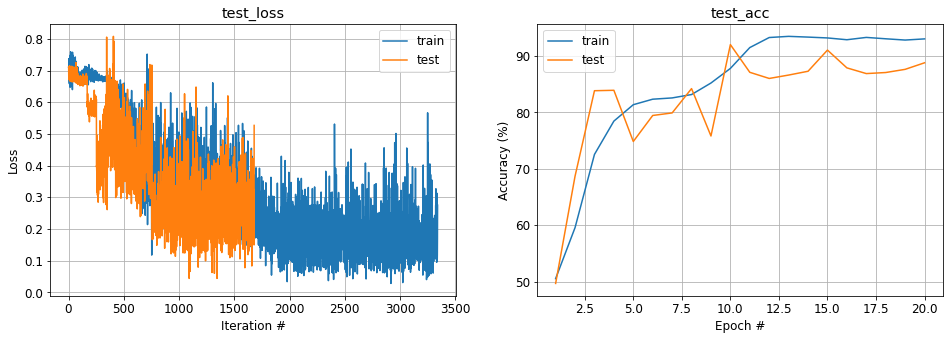

In [12]:
from cs236781.plot import plot_fit

plot_fit(fit_result, log_loss=False, train_test_overlay=True);

### Decision Boundary

An important part of understanding what a non-linear classifier like our MLP is doing is visualizing it's decision boundaries. When we only have two input features, these are relatively simple to visualize, since we can simply plot our data on the plane, and evaluate our classifier on a constant 2D grid in order to approximate the decision boundary.

**TODO**: Implement the `plot_decision_boundary_2d` function in the `hw2/classifier.py` module.

C:\Users\toona\anaconda3\envs\cs236781-hw2\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


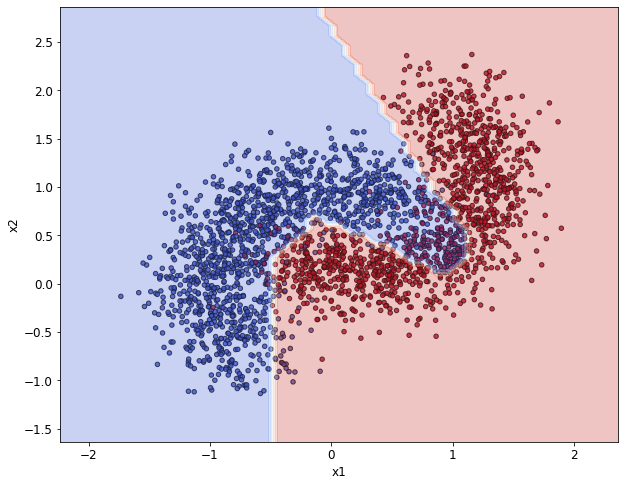

In [13]:
from hw2.classifier import plot_decision_boundary_2d
fig, ax = plot_decision_boundary_2d(model, *dl_valid.dataset.tensors)

### Threshold Selection

Another important component, especially in the context of binary classification is threshold selection. Until now, we arbitrarily chose a threshold of 0.5 when deciding the class label based on the probability score we calculated via softmax. In other words, we classified a sample to class 1 (the 'positive' class) when it's probability score was greater or equal to 0.5.

However, in real-world classifiction problems we'll need to choose our threshold wisely based on the domain-specific requirements of the problem.
For example, depending on our application, we might care more about high sensitivity (correctly classifying positive examples), while for other applications specificity (correctly classifying negative examples) is more important. 

One way to understand the mistakes a model is making is to look at its [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix). From it, we easily see e.g. the false-negative rate (FNR) and false-positive rate (FPR).

Let's look at the confusion matrices on the test and validation data using the model we trained above.

tn=0.463,fp=0.0358,fn=0.0274,tp=0.474
FPR=0.0719,FNR=0.0546
tn=0.478,fp=0.0255,fn=0.0866,tp=0.41
FPR=0.0507,FNR=0.174


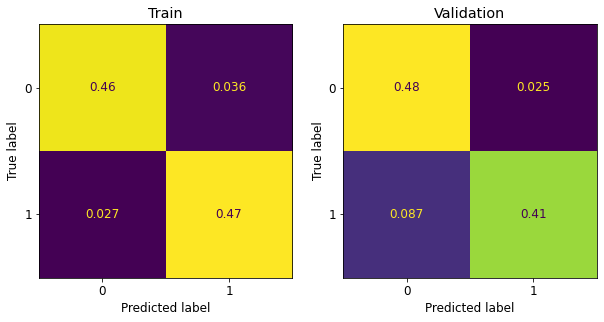

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion(classifier, x: np.ndarray, y: np.ndarray, ax=None):
    y_hat = classifier.classify(torch.from_numpy(x).to(torch.float32)).numpy()
    conf_mat = confusion_matrix(y, y_hat, normalize='all')
    ConfusionMatrixDisplay(conf_mat).plot(ax=ax, colorbar=False)
    tn, fp, fn, tp = conf_mat.ravel()
    FPR = fp/(fp+tn)
    FNR = fn/(fn+tp)
    print(f'{tn=:.3},{fp=:.3},{fn=:.3},{tp=:.3}')
    print(f'{FPR=:.3},{FNR=:.3}')
    
model.threshold = 0.5

_, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Train"); axes[1].set_title("Validation");
plot_confusion(model, X_train, y_train, ax=axes[0])
plot_confusion(model, X_valid, y_valid, ax=axes[1])

We can see that the model makes a different number of false-posiive and false-negative errors.
Clearly, this proportion would change if the classification threshold was different.

A very common way to select the classification threshold is to find a threshold which optimally balances between the FPR and FNR.
This can be done by plotting the model's [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve, which shows 1-FNR vs. FPR for multiple threshold values, and selecting the point closest to the ideal point (`(0, 1)`).

**TODO**: Implement the `select_roc_thresh` function in the `hw2.classifier` module.

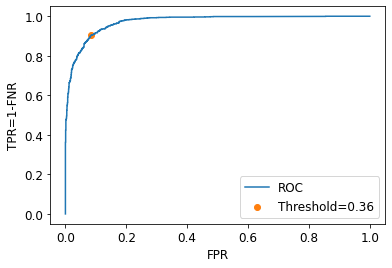

In [15]:
from hw2.classifier import select_roc_thresh

optimal_thresh = select_roc_thresh(model, *dl_valid.dataset.tensors, plot=True)

Let's see the effect of our threshold selection on the confusion matrix and decision boundary.

tn=0.44,fp=0.0587,fn=0.0154,tp=0.486
FPR=0.118,FNR=0.0307
tn=0.462,fp=0.0416,fn=0.0484,tp=0.448
FPR=0.0827,FNR=0.0974


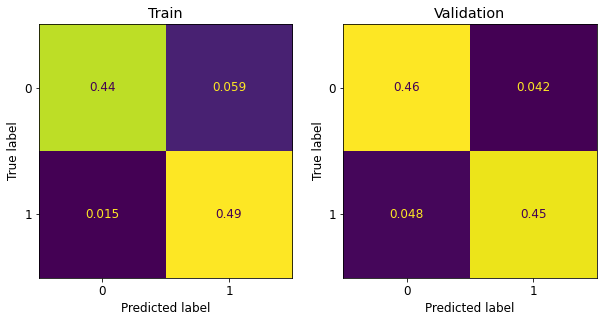

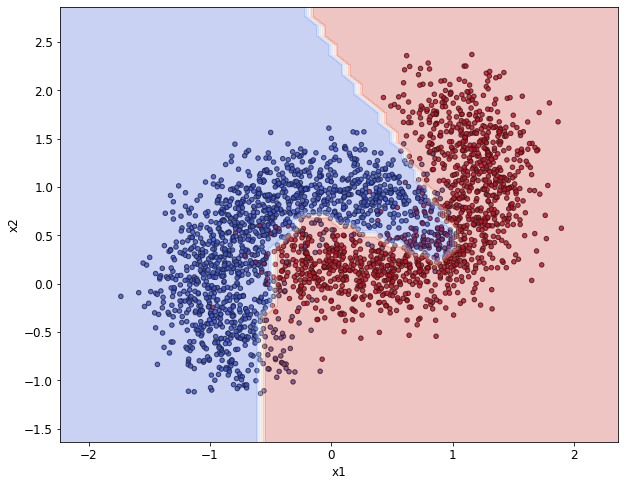

In [16]:
model.threshold = optimal_thresh

_, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].set_title("Train"); axes[1].set_title("Validation");
plot_confusion(model, X_train, y_train, ax=axes[0])
plot_confusion(model, X_valid, y_valid, ax=axes[1])
fig, ax = plot_decision_boundary_2d(model, *dl_valid.dataset.tensors)

### Architecture Experiments

Now, equipped with the tools we've implemented so far we'll expertiment with various MLP architectures.
We'll seek to study the effect of the models depth (number of hidden layers) and width (number of neurons per hidden layer) on the its decision boundaries and the resulting performance.
After training, we will use the validation set for threshold selection, and seek to maximize the performance on the test set.

**TODO**: Implement the `mlp_experiment` function in `hw2/experiments.py`.
You are free to configure any model and optimization hyperparameters however you like, except for the specified `width` and `depth`.
Experiment with various options for these other hyperparameters and try to obtain the best results you can.

  0%|          | 0/12 [00:00<?, ?it/s]

width=2,depth=1
width=2,depth=2
width=2,depth=4
width=8,depth=1
width=8,depth=2
width=8,depth=4
width=32,depth=1
width=32,depth=2
width=32,depth=4
width=128,depth=1
width=128,depth=2
width=128,depth=4
49.53634285926819 seconds


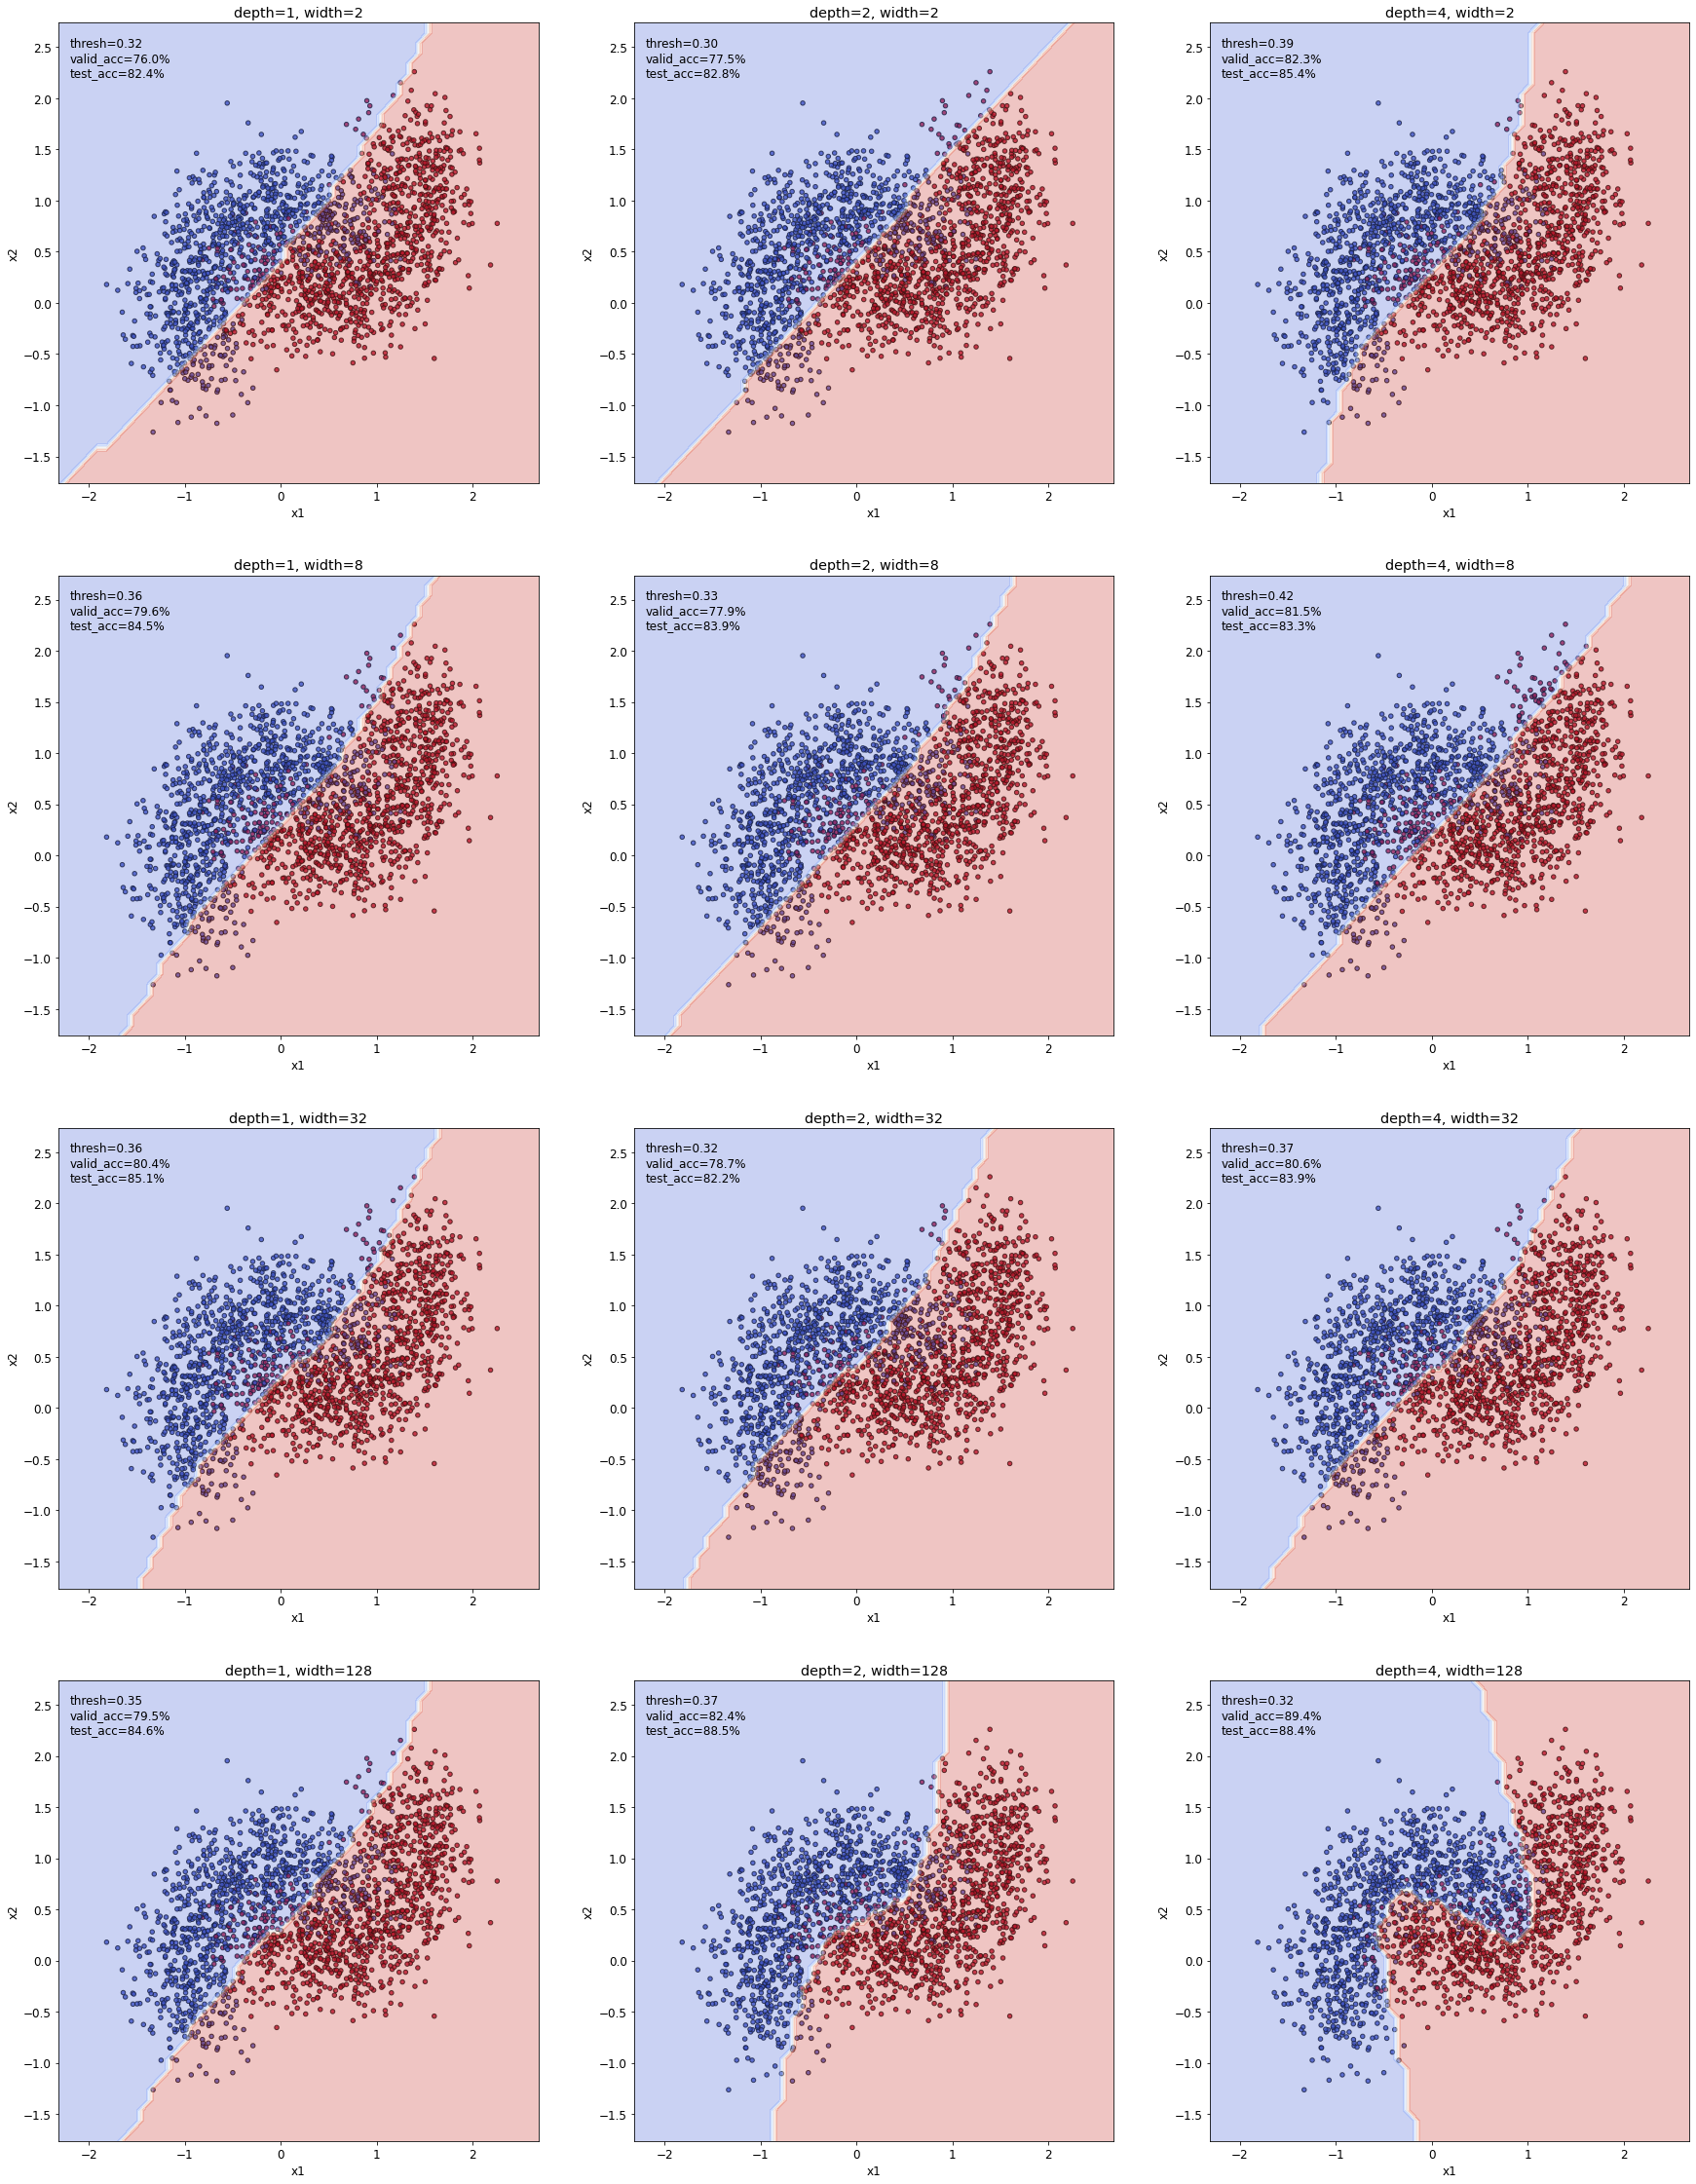

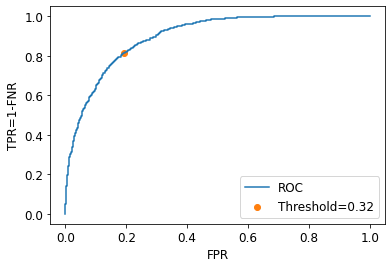

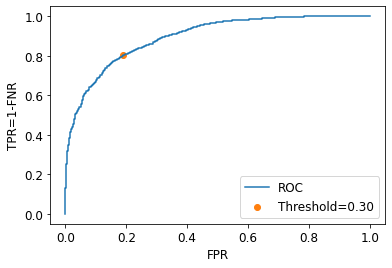

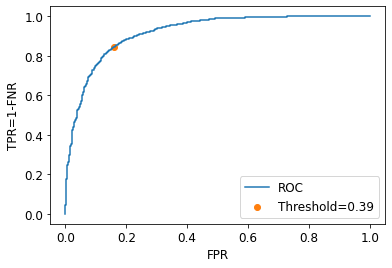

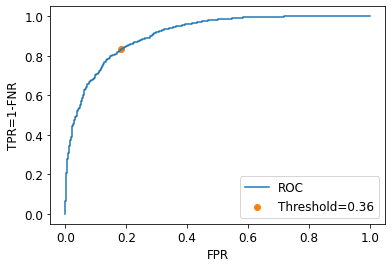

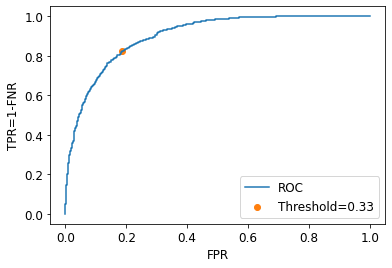

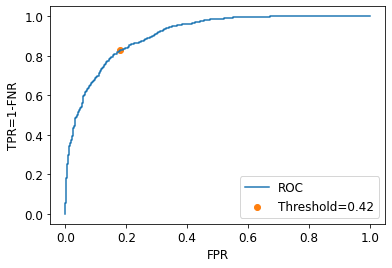

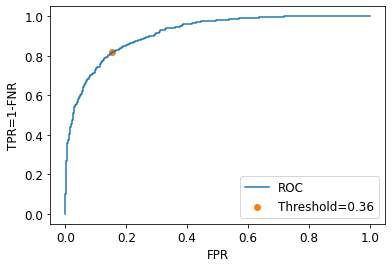

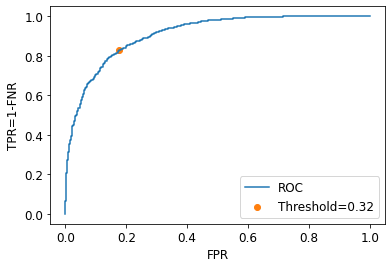

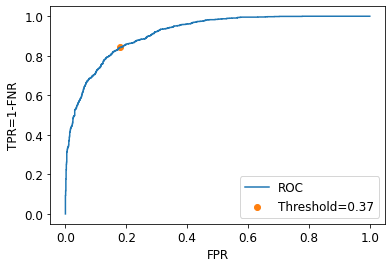

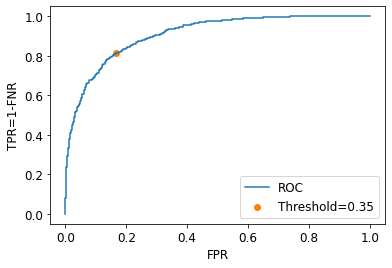

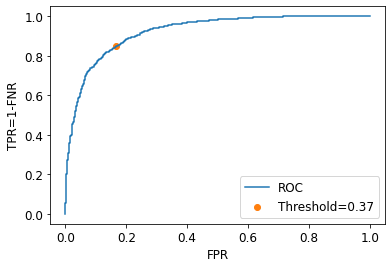

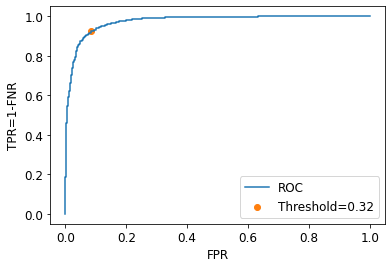

In [17]:
from itertools import product
from tqdm.auto import tqdm
from hw2.experiments import mlp_experiment
torch.manual_seed(seed)
import time

n_epochs = 10 # shold be 10
depths = [1, 2, 4]
widths = [2, 8, 32, 128]

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
# print(f'{device.type=}')

exp_configs = product(enumerate(widths), enumerate(depths))
fig, axes = plt.subplots(len(widths), len(depths), figsize=(10*len(depths), 10*len(widths)), squeeze=False)
test_accs = []
t0 = time.time()

      
for (i, width), (j, depth) in tqdm(list(exp_configs)):
    print(f'{width=},{depth=}')
    model, thresh, valid_acc, test_acc = mlp_experiment(
        depth, width, dl_train, dl_valid, dl_test, n_epochs=n_epochs
    )
    test_accs.append(test_acc)
    fig, ax = plot_decision_boundary_2d(model, *dl_test.dataset.tensors, ax=axes[i, j])
    
    ax.set_title(f"{depth=}, {width=}")
    ax.text(ax.get_xlim()[0]*.95, ax.get_ylim()[1]*.95, f"{thresh=:.2f}\n{valid_acc=:.1f}%\n{test_acc=:.1f}%", va="top")
fig.savefig('All_Experiments.png') 

print('{} seconds'.format(time.time() - t0))   

# Assert minimal performance requirements.
# You should be able to do better than these by at least 5%.
test.assertGreaterEqual(np.min(test_accs), 75.0)
test.assertGreaterEqual(np.quantile(test_accs, 0.75), 85.0)

### Questions

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw2/answers.py`.


In [18]:
from cs236781.answers import display_answer
import hw2.answers

#### Question 1 

Consider the first binary classifier you trained in this notebook and the loss/accuracy curves we plotted for it on the train and validation sets, as well as the decision boundary plot. 

Based on those plots, explain **qualitatively** whether or now your model has:
1. High Optimization error?
2. High Generalization error?
2. High Approximation error?

Explain your answers for each of the above.
Since this is a qualitative question, assume "high" simply means "I would take measures in order to decrease it further".

In [19]:
display_answer(hw2.answers.part1_q1)


**Your answer:**

From tutorial :


How do we mitigate these errors in the practice of machine learning?

    Optimization error: Mini batches; GD variants like stochastic gradient, momentum, Adam, etc (we'll see later in the course).

    Generalization error: Get more data; get data which better represents D

    ; train-test splits; cross validation; early stopping; regularization.

    Approximation error: Use a powerful hypothesis class (e.g. DNN); more parameters; tailoring to the domain (e.g. CNN for images).



1.Generalization error - This error is measured on test set. How model we trained on train set is performing on test set. If train accuracy and test accuracy are in the same values so the model has good generalization , if test accuracy much worse than train accuracy - the model has High generalezation error.

In our case we trained fo 20 epochs with parameters written above and got after 20 epochs:
train accuracy = 93 %
test acuracy = 88.8 %
The Generalization error is pretty low, because performance on test set pretty same like on train test.

2.Aproximation error - This error is low when expressivness of model is High ,meaning very large amount of parameters relatively to $len(X)$.
In our case we have small amount of parameters (258) , and pretty complicated dataset, so thee approximation error is relativly high. Need to choose model with larger amount of parameters.

3.Optimization error - This error is comes from otimization problem and can be improved by following parameters and techniques:
* Mini batches
* GD variants like stochastic gradient
* Momentum
* Adam




#### Question 2 

Consider the first binary classifier you trained in this notebook and the confusion matrices we plotted for it. 

For the **validation** dataset, would you expect the FPR or the FNR to be higher, and why? Recall that you have full knowledge of the data generating process.


In [20]:
display_answer(hw2.answers.part1_q2)


For validation set the TP is going to be lower and FP higher ,so the FNR is going to be higher.
!!!!!!!!!!!!!!!EXplain why!!!!!!!!!!!!!!!!!!!!

tn=0.47,fp=0.0281,fn=0.0338,tp=0.468
FPR=0.0564,FNR=0.0673
tn=0.49,fp=0.0127,fn=0.109,tp=0.388
FPR=0.0253,FNR=0.219



#### Question 3 

You're training a binary classifier screening of a large cohort of patients for some disease, with the aim to detect the disease early, before any symptoms appear.
You train the model on easy-to-obtain features, so screening each individual patient is simple and low-cost.
In case the model classifies a patient as sick, she must then be sent to furhter testing in order to confirm the illness. Assume that these further tests are expensive and involve high-risk to the patient. Assume also that once diagnosed, a low-cost treatment exists.

You wish to screen as many people as possible at the lowest possible cost and loss of life.
Would you still choose the same "optimal" point on the ROC curve as above?
If not, how would you choose it?
Answer these questions for two possible scenarios:

1. A person with the disease will develop non-lethal symptoms that immediately confirm the diagnosis and can then be treated.
2. A person with the disease shows no clear symptoms and may die with high probability if not diagnosed early enough, either by your model or by the expensive test.

Explain your answers.

In [21]:
display_answer(hw2.answers.part1_q3)


The goal is to detect the desiase at the lowest possible cost and loss of life  **before any symptoms appear** 


1.A person with the disease will develop non-lethal symptoms that immediately confirm the diagnosis and can then be treated.

In this case we still will use the optimal ROC value for threshold because the simptoms are not lethal and we are optimazing TPR vs FPR to get as much TPR .

2.A person with the disease shows no clear symptoms and may die with high probability if not diagnosed early enough, either by your model or by the expensive test.
In this case there are no clear early symptoms,so we want to choose threshold , such will yield **lowest FNR** , meaning highest TPR rate, that will yield higher FPR ,meaning more patients with no desies will be classified as positive to desies and needed to be send to further testing.Here we are optimizing for patients survaval.




#### Question 4 

Analyze your results from the Architecture Experiment.

1. Explain the decision boundaries and model performance you obtained for the columns (fixed `depth`, `width` varies).
2. Explain the decision boundaries and model performance you obtained for the rows (fixed `width`, `depth` varies).
3. Compare and explain the results for the following pairs of configurations, which have the same number of total parameters:
    - `depth=1, width=32` and `depth=4, width=8`
    - `depth=1, width=128` and `depth=4, width=32`
3. Explain the effect of threshold selection on the validation set: did it improve the results on the test set? why?

In [22]:
display_answer(hw2.answers.part1_q4)



1.Explain the decision boundaries and model performance you obtained for the columns (fixed depth, width varies).

Answer:
For fixed depth model has pieswise linear classification ,as width grows the model have more pieses of classification . We know from Aproxiamation theary that we can describe every function as number of neurons in layer goes to $N$ $\rightarrow$ $\infty$.
With growing width model classification perfoms better.

2.Explain the decision boundaries and model performance you obtained for the rows (fixed width, depth varies).

For fixed width the behavior of the model is such:
With small number of width parameters ,model is overfitting and not generalizing well,but when the amout of width parameters is high (128) , so the performance getting better with depth growing.
With growing depth model classification perfoms better , only when width is high enoght,otherwise the model overfits.


3.Compare and explain the results for the following pairs of configurations, which have the same number of total parameters:

Answer:

    for depth=1, width=32 ,validation accuracy 78.9%,test accuracy is 88.1% 
    for depth=4, width=8  ,validation accuracy 85.0%,test accuracy is 80.5%
Here shallow model performs better ,than deep model with same amount of parameters,because deeper model overfits the training data.

!!!!!!!!!!!!!!!!!! Explain why  !!!!!!!!!!!!!!!
    
    for depth=1, width=128 ,validation accuracy 91.4%,test accuracy is 89.8% 
    for depth=4, width=32  ,validation accuracy 67.8%,test accuracy is 81.8%
Shallow model performs optimally, and deep model is underfits the training data,probably needs regularization.

!!!!!!!!!!!!!!!!!! Explain why  !!!!!!!!!!!!!!!

4.Explain the effect of threshold selection on the validation set: did it improve the results on the test set? why?

Answer:

Threshold is hyper-parameters, and HP are optimized on validation set after the model already trained on training set.Threshold selection allows the model classify better and inprove TPR . 

